# Bike Sharing 数据集上的回归分析

1、 任务描述 请在Capital Bikeshare （美国Washington, D.C.的一个共享单车公司）提供的自行车数据上进行回归分析。训练数据为2011年的数据，要求预测2012年每天的单车共享数量。

原始数据集地址：http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset 1) 文件说明 
day.csv: 按天计的单车共享次数（作业只需使用该文件） 
hour.csv: 按小时计的单车共享次数（无需理会） 
readme：数据说明文件

2) 字段说明 
Instant记录号 
Dteday：日期 
Season：季节（1=春天、2=夏天、3=秋天、4=冬天） 
yr：年份，(0: 2011, 1:2012) 
mnth：月份( 1 to 12) 
hr：小时 (0 to 23) （只在hour.csv有，作业忽略此字段） 
holiday：是否是节假日 
weekday：星期中的哪天，取值为0～6 
workingday：是否工作日 1=工作日 （是否为工作日，1为工作日，0为非周末或节假日 weathersit：天气（1：晴天，多云 2：雾天，阴天 3：小雪，小雨 4：大雨，大雪，大雾） temp：气温摄氏度 
atemp：体感温度 
hum：湿度 
windspeed：风速 

casual：非注册用户个数 
registered：注册用户个数 
cnt：给定日期（天）时间（每小时）总租车人数，响应变量y
casual、registered和cnt三个特征均为要预测的y，作业里只需对cnt进行预测

In [1]:
# 导入必要的工具包
# 数据读取及基本处理
import pandas as pd
import numpy as np

#模型
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

#模型评估
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  #评价回归预测模型的性能

#可视化
import matplotlib.pyplot as plt

In [2]:
# 读入数据
data = pd.read_csv("FE_day.csv")
data.head()

,instant,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,...,weekday_5,weekday_6,temp,atemp,hum,windspeed,holiday,workingday,yr,cnt
0,1,1,0,0,0,1,0,0,0,0,...,0,1,0.355170,0.373517,0.828620,0.284606,0,0,0,985
1,2,1,0,0,0,1,0,0,0,0,...,0,0,0.379232,0.360541,0.715771,0.466215,0,0,0,801
2,3,1,0,0,0,1,0,0,0,0,...,0,0,0.171000,0.144830,0.449638,0.465740,0,1,0,1349
3,4,1,0,0,0,1,0,0,0,0,...,0,0,0.175530,0.174649,0.607131,0.284297,0,1,0,1562
4,5,1,0,0,0,1,0,0,0,0,...,0,0,0.209120,0.197158,0.449313,0.339143,0,1,0,1600


In [3]:
#选取2011年的数据作为训练数据
train = data[data.yr ==0]
train.drop(['instant','yr'],axis=1,inplace = True)
print("train : " + str(train.shape))

test = data[data.yr == 1]
testID = test['instant']
test.drop(['instant','yr'],axis=1, inplace = True)
print("test : " + str(test.shape))

train : (365, 33)
test : (366, 33)


/Users/qing/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/qing/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
train.head()

,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,...,weekday_4,weekday_5,weekday_6,temp,atemp,hum,windspeed,holiday,workingday,cnt
0,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0.355170,0.373517,0.828620,0.284606,0,0,985
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0.379232,0.360541,0.715771,0.466215,0,0,801
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0.171000,0.144830,0.449638,0.465740,0,1,1349
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0.175530,0.174649,0.607131,0.284297,0,1,1562
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0.209120,0.197158,0.449313,0.339143,0,1,1600


**准备训练数据**

In [5]:
y_train = train["cnt"]
X_train = train.drop(['cnt'], axis = 1)

y_test = test["cnt"]
X_test = test.drop(['cnt'], axis = 1)

In [6]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 初始化对目标值的标准化器
# 对y标准化不是必须，但对其进行标准化可以使得不同问题w的取值范围相对相同

#自己实现试试...,这些参数需要保留，对测试集预测完后还需要对其进行反变换
mean_y = y_train.mean()
std_y = y_train.std()
y_train = (y_train - mean_y)/std_y

y_test = (y_test - mean_y)/std_y

mean_test_y = y_test.mean()
#mean_train_y = 0
mean_diff = mean_test_y;

print("mean y diff :", mean_diff)
#ss_y = StandardScaler()
#y_train = ss_y.fit_transform(y_train.values.reshape(-1, 1))
#y_test = ss_y.transform(y_test.reshape(-1, 1))

('mean y diff :', 1.5914175510574313)


**1* Linear Regression without regularization**
最小二乘线性回归
最小二乘没有超参数需要调优，直接用全体训练数据训练模型

In [7]:
# Linear Regression
# 1. 生成学习器实例
lr = LinearRegression()

#2. 在训练集上训练学习器
lr.fit(X_train, y_train)

#3.训练上测试，得到训练误差，实际任务中这一步不需要
# Look at predictions on training and validation set
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
y_test_pred += mean_diff

rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test,y_test_pred))
print("RMSE on Training set :", rmse_train)
print("RMSE on Test set :", rmse_test)

r2_score_train = r2_score(y_train,y_train_pred)
r2_score_test = r2_score(y_test,y_test_pred)
print("r2_score on Training set :", r2_score_train)
print("r2_score on Test set :", r2_score_test)

('RMSE on Training set :', 0.39991682792856953)
('RMSE on Test set :', 0.75032220972214492)
('r2_score on Training set :', 0.83962715307674751)
('r2_score on Test set :', 0.66457318802098153)


该数据集样本数较少，不适合用随机梯度下降方法求解。

**2* Linear Regression with Ridge regularization (L2 penalty)**

In [8]:
#RidgeCV缺省的score是mean squared errors 
# 1. 生成学习器实例
# RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, normalize=False, scoring=None, cv=None, gcv_mode=None, store_cv_values=False)
alphas = [0.01, 0.1, 1, 10, 100, 1000]
ridge = RidgeCV(alphas = alphas,store_cv_values=True )

# 2. 用训练数据度模型进行训练
# RidgeCV采用的是广义交叉验证（Generalized Cross-Validation），留一交叉验证（N-折交叉验证）的一种有效实现方式
ridge.fit(X_train, y_train)

#通过交叉验证得到的最佳超参数alpha
alpha = ridge.alpha_
print("Best alpha :", alpha)

# 交叉验证估计的测试误差
mse_cv = np.mean(ridge.cv_values_, axis = 0)
rmse_cv = np.sqrt(mse_cv)
print("cv of rmse :", min(rmse_cv))

#训练上测试，训练误差，实际任务中这一步不需要
y_train_pred = ridge.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))

y_test_pred = ridge.predict(X_test)
y_test_pred += mean_diff
rmse_test = np.sqrt(mean_squared_error(y_test,y_test_pred))

print("RMSE on Training set :", rmse_train)
print("RMSE on Test set :", rmse_test)

r2_score_train = r2_score(y_train,y_train_pred)
r2_score_test = r2_score(y_test,y_test_pred)
print("r2_score on Training set :", r2_score_train)
print("r2_score on Test set :", r2_score_test)

('Best alpha :', 1.0)
('cv of rmse :', 0.43446097786711985)
('RMSE on Training set :', 0.40016458243626751)
('RMSE on Test set :', 0.75084648270645393)
('r2_score on Training set :', 0.83942838472999115)
('r2_score on Test set :', 0.66410427839481767)


Ridge picked 32 features and eliminated the other 0 features


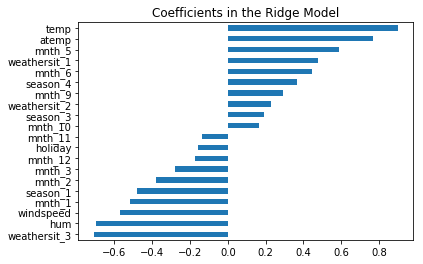

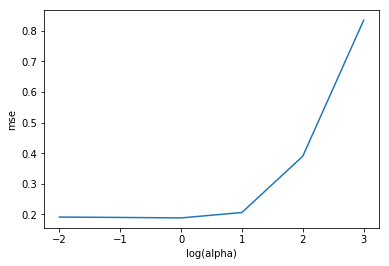

In [9]:
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")

#正系数值最大的10个特征和负系数值最小（绝对值大）的10个特征
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

mse_mean = np.mean(ridge.cv_values_, axis = 0)
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas),1)) 

plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()

**3* Linear Regression with Lasso regularization (L1 penalty)**

('Best alpha :', 0.00058279194197177178)


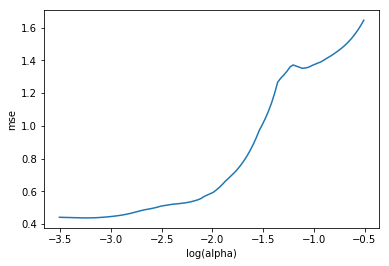

('cv of rmse :', 0.66118829457813577)
Lasso picked 26 features and eliminated the other 6 features


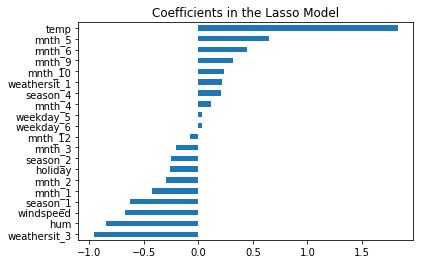

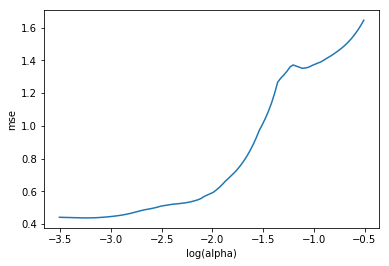

('RMSE on Training set :', 0.39877183520330761)
('RMSE on Test set :', 0.74817785321587582)
('r2_score on Training set :', 0.8405441581283899)
('r2_score on Test set :', 0.66648769046990797)


In [10]:
# 3* Lasso
lasso = LassoCV()
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses) 
#plt.plot(np.log10(lasso.alphas_)*np.ones(3), [0.3, 0.4, 1.0])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()    

mse_cv = np.mean(lasso.mse_path_, axis = 1)
rmse_cv = np.sqrt(mse_cv)
print("cv of rmse :", min(rmse_cv))

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses) 
#plt.plot(np.log10(lasso.alphas_)*np.ones(3), [0.3, 0.4, 1.0])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show() 


y_train_pred = lasso.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
print("RMSE on Training set :", rmse_train)


y_test_pred = lasso.predict(X_test)
y_test_pred += mean_diff

rmse_test = np.sqrt(mean_squared_error(y_test,y_test_pred))
print("RMSE on Test set :", rmse_test)

r2_score_train = r2_score(y_train,y_train_pred)
r2_score_test = r2_score(y_test,y_test_pred)
print("r2_score on Training set :", r2_score_train)
print("r2_score on Test set :", r2_score_test)

## 对测试集进行测试，生成提交文件

In [11]:
y_test_pred = lasso.predict(X_test)
y_test_pred += mean_diff
y_test_pred = y_test_pred * std_y +  mean_y

#生成提交测试结果

df = pd.DataFrame({"instant":testID, 'cnt':y_test_pred})
#df.reindex(columns=['instant'])
#y = pd.Series(data = y_test_pred, name = 'cnt')
#df = pd.concat([testID, y], axis = 1, ignore_index=True)
df.to_csv('submission.csv')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 365 to 730
Data columns (total 2 columns):
cnt        366 non-null float64
instant    366 non-null int64
dtypes: float64(1), int64(1)
memory usage: 18.6 KB
